# Linear Regression Implementation from Scratch
:label:`sec_linear_scratch`

We are now ready to work through 
a fully functioning implementation 
of linear regression. 
In this section, 
(**we will implement the entire method from scratch,
including (i) the model; (ii) the loss function;
(iii) a minibatch stochastic gradient descent optimizer;
and (iv) the training function 
that stitches all of these pieces together.**)
Finally, we will run our synthetic data generator
from :numref:`sec_synthetic-regression-data`
and apply our model
on the resulting dataset. 
While modern deep learning frameworks 
can automate nearly all of this work,
implementing things from scratch is the only way
to make sure that you really know what you are doing.
Moreover, when it is time to customize models,
defining our own layers or loss functions,
understanding how things work under the hood will prove handy.
In this section, we will rely only 
on tensors and automatic differentiation.
Later, we will introduce a more concise implementation,
taking advantage of the bells and whistles of deep learning frameworks 
while retaining the structure of what follows below.

# 선형 회귀 처음부터 구현
:label:`sec_linear_scratch`

이제 선형 회귀를 완벽하게 구현할 준비가 되었습니다.이 섹션에서는
(**(i) 모델, (ii) 손실 함수,
(iii) 미니 배치 확률적 경사 하강법 최적화기,
(iv) 이 모든 부분을 연결하는 학습 함수를 포함하여 전체 방법을 처음부터 구현합니다.**)
마지막으로, :numref:`sec_synthetic-regression-data`에서 합성 데이터 생성기를 실행하고
결과 데이터 세트에 모델을 적용합니다.최신 딥러닝 프레임워크는 이러한 작업의 거의 대부분을 자동화할 수 있지만,
무엇을 하는지 확실히 알 수 있는 유일한 방법은 처음부터 구현하는 것입니다.더욱이, 모델을 맞춤 설정할 때,
자체적인 계층이나 손실 함수를 정의하고,
내부적으로 어떻게 작동하는지 이해하는 것이 유용할 것입니다.이 섹션에서는
텐서와 자동 미분에만 의존합니다.나중에 딥 러닝 프레임워크의 다양한 기능을 활용하면서
아래에 나오는 구조는 그대로 유지하는 더욱 간결한 구현을 소개하겠습니다.


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Defining the Model

[**Before we can begin optimizing our model's parameters**] by minibatch SGD,
(**we need to have some parameters in the first place.**)
In the following we initialize weights by drawing
random numbers from a normal distribution with mean 0
and a standard deviation of 0.01. 
The magic number 0.01 often works well in practice, 
but you can specify a different value 
through the argument `sigma`.
Moreover we set the bias to 0.
Note that for object-oriented design
we add the code to the `__init__` method of a subclass of `d2l.Module` (introduced in :numref:`subsec_oo-design-models`).

## 모델 정의

[**모델 매개변수 최적화를 시작하기 전에**] 미니배치 SGD를 사용합니다.
(**먼저 몇 가지 매개변수가 필요합니다.**)
다음에서는 평균이 0이고 표준 편차가 0.01인 정규 분포에서 난수를 추출하여 가중치를 초기화합니다.마법의 숫자 0.01은 실제로 잘 작동하지만, `sigma` 인수를 통해 다른 값을 지정할 수 있습니다.또한 편향을 0으로 설정합니다.
객체 지향 설계의 경우, `d2l.Module`의 하위 클래스( :numref:`subsec_oo-design-models`에서 소개됨)의 `__init__` 메서드에 코드를 추가합니다.


In [2]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

Next we must [**define our model,
relating its input and parameters to its output.**]
Using the same notation as :eqref:`eq_linreg-y-vec`
for our linear model we simply take the matrix--vector product
of the input features $\mathbf{X}$ 
and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.
The product $\mathbf{Xw}$ is a vector and $b$ is a scalar.
Because of the broadcasting mechanism 
(see :numref:`subsec_broadcasting`),
when we add a vector and a scalar,
the scalar is added to each component of the vector.
The resulting `forward` method 
is registered in the `LinearRegressionScratch` class
via `add_to_class` (introduced in :numref:`oo-design-utilities`).

다음으로 [**모델을 정의하고,
모델의 입력과 매개변수를 출력과 연관시켜야 합니다.**]
:eqref:`eq_linreg-y-vec`와 동일한 표기법을 사용하여
선형 모델의 경우, 입력 피처 $\mathbf{X}$와 모델 가중치 $\mathbf{w}$의 행렬-벡터 곱을 구하고, 각 예제에 오프셋 $b$를 더합니다.곱 $\mathbf{Xw}$는 벡터이고 $b$는 스칼라입니다.브로드캐스팅 메커니즘(:numref:`subsec_broadcasting` 참조) 때문에
벡터와 스칼라를 더하면
스칼라는 벡터의 각 구성 요소에 더해집니다.결과적으로 생성된 `forward` 메서드는 `add_to_class`(:numref:`oo-design-utilities`에서 도입됨)를 통해 `LinearRegressionScratch` 클래스에 등록됩니다.


In [3]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

## Defining the Loss Function

Since [**updating our model requires taking
the gradient of our loss function,**]
we ought to (**define the loss function first.**)
Here we use the squared loss function
in :eqref:`eq_mse`.
In the implementation, we need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following method
will also have the same shape as `y_hat`. 
We also return the averaged loss value
among all examples in the minibatch.

## 손실 함수 정의

[**모델을 업데이트하려면 손실 함수의 기울기를
받아야 하므로**]
(**먼저 손실 함수를 정의해야 합니다.**)
여기서는 :eqref:`eq_mse`에 있는 제곱 손실 함수를 사용합니다.구현 과정에서는 실제 값 `y`를 예측 값의 형태인 `y_hat`으로 변환해야 합니다.다음 메서드에서 반환되는 결과도 `y_hat`과 동일한 형태를 갖습니다.또한 미니 배치의 모든 예제에 대한 평균 손실 값을 반환합니다.


In [4]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

## Defining the Optimization Algorithm

As discussed in :numref:`sec_linear_regression`,
linear regression has a closed-form solution.
However, our goal here is to illustrate 
how to train more general neural networks,
and that requires that we teach you 
how to use minibatch SGD.
Hence we will take this opportunity
to introduce your first working example of SGD.
At each step, using a minibatch 
randomly drawn from our dataset,
we estimate the gradient of the loss
with respect to the parameters.
Next, we update the parameters
in the direction that may reduce the loss.

The following code applies the update, 
given a set of parameters, a learning rate `lr`.
Since our loss is computed as an average over the minibatch, 
we do not need to adjust the learning rate against the batch size. 
In later chapters we will investigate 
how learning rates should be adjusted
for very large minibatches as they arise 
in distributed large-scale learning.
For now, we can ignore this dependency.

## 최적화 알고리즘 정의

:numref:`sec_linear_regression`에서 설명한 것처럼
선형 회귀는 닫힌 형태의 해를 가집니다.하지만 여기서의 목표는
더 일반적인 신경망을 학습하는 방법을 보여주는 것이며,
이를 위해서는
미니 배치 SGD를 사용하는 방법을 알려드려야 합니다.따라서 이 기회에 SGD의 첫 번째 실제 예제를 소개해 드리겠습니다.각 단계에서 데이터세트에서 무작위로 추출한 미니 배치를 사용하여
매개변수에 대한 손실의 기울기를 추정합니다.그런 다음, 손실을 줄일 수 있는 방향으로 매개변수를 업데이트합니다.다음 코드는 주어진 매개변수 집합과 학습률 `lr`에 대해 업데이트를 적용합니다.손실은 미니 배치에 대한 평균으로 계산되므로
배치 크기에 따라 학습률을 조정할 필요가 없습니다.이후 장에서는 분산형 대규모 학습에서 매우 큰 미니배치가 발생할 때 학습률을 어떻게 조정해야 하는지 살펴보겠습니다.지금은 이 종속성을 무시해도 됩니다.


We define our `SGD` class,
a subclass of `d2l.HyperParameters` (introduced in :numref:`oo-design-utilities`),
to have a similar API 
as the built-in SGD optimizer.
We update the parameters in the `step` method.
The `zero_grad` method sets all gradients to 0,
which must be run before a backpropagation step.

`SGD` 클래스를 정의합니다. 이 클래스는 `d2l.HyperParameters`(:numref:`oo-design-utilities`에서 도입됨)의 하위 클래스이며, 내장 SGD 옵티마이저와 유사한 API를 갖습니다.`step` 메서드에서 매개변수를 업데이트합니다.`zero_grad` 메서드는 모든 그래디언트를 0으로 설정합니다.
이 설정은 역전파 단계 전에 실행되어야 합니다.


In [5]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

We next define the `configure_optimizers` method, which returns an instance of the `SGD` class.

다음으로 `SGD` 클래스의 인스턴스를 반환하는 `configure_optimizers` 메서드를 정의합니다.


In [6]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

## Training

Now that we have all of the parts in place
(parameters, loss function, model, and optimizer),
we are ready to [**implement the main training loop.**]
It is crucial that you understand this code fully
since you will employ similar training loops
for every other deep learning model
covered in this book.
In each *epoch*, we iterate through 
the entire training dataset, 
passing once through every example
(assuming that the number of examples 
is divisible by the batch size). 
In each *iteration*, we grab a minibatch of training examples,
and compute its loss through the model's `training_step` method. 
Then we compute the gradients with respect to each parameter. 
Finally, we will call the optimization algorithm
to update the model parameters. 
In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$
 
Recall that the synthetic regression dataset 
that we generated in :numref:``sec_synthetic-regression-data`` 
does not provide a validation dataset. 
In most cases, however, 
we will want a validation dataset 
to measure our model quality. 
Here we pass the validation dataloader 
once in each epoch to measure the model performance.
Following our object-oriented design,
the `prepare_batch` and `fit_epoch` methods
are registered in the `d2l.Trainer` class
(introduced in :numref:`oo-design-training`).

## 학습

이제 모든 부분(매개변수, 손실 함수, 모델, 옵티마이저)이 준비되었으므로
[**주요 학습 루프를 구현할**] 준비가 되었습니다.
이 책에서 다루는 다른 모든 딥 러닝 모델에 유사한 학습 루프를 사용할 것이므로 이 코드를 완전히 이해하는 것이 중요합니다.각 *에포크*마다 전체 학습 데이터셋을 반복하며
모든 예제를 한 번씩 통과합니다(예제의 개수가 배치 크기로 나누어 떨어진다고 가정).매 *반복*마다 학습 예제의 미니 배치를 가져오고
모델의 `training_step` 메서드를 통해 손실을 계산합니다.그런 다음 각 매개변수에 대한 기울기를 계산합니다.마지막으로 최적화 알고리즘을 호출하여
모델 매개변수를 업데이트합니다.요약하면 다음 루프를 실행합니다.* 매개변수 초기화 $(\mathbf{w}, b)$* 끝날 때까지 반복* 기울기 계산 $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$* 매개변수 업데이트 $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$합성 회귀 데이터세트가:numref:``sec_synthetic-regression-data``에서 생성한 것입니다.검증 데이터 세트를 제공하지 않습니다.하지만 대부분의 경우
모델 품질을 측정하기 위해 검증 데이터셋이 필요합니다.여기서는 모델 성능을 측정하기 위해 각 에포크마다 한 번씩 검증 데이터로더를 전달합니다.객체 지향 설계에 따라
`prepare_batch` 및 `fit_epoch` 메서드는 `d2l.Trainer` 클래스에 등록됩니다(:numref:`oo-design-training`에서 도입).


In [7]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

In [8]:
@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

We are almost ready to train the model,
but first we need some training data.
Here we use the `SyntheticRegressionData` class 
and pass in some ground truth parameters.
Then we train our model with 
the learning rate `lr=0.03` 
and set `max_epochs=3`. 
Note that in general, both the number of epochs 
and the learning rate are hyperparameters.
In general, setting hyperparameters is tricky
and we will usually want to use a three-way split,
one set for training, 
a second for hyperparameter selection,
and the third reserved for the final evaluation.
We elide these details for now but will revise them
later.

모델을 학습할 준비가 거의 되었지만,
먼저 학습 데이터가 필요합니다.여기서는 `SyntheticRegressionData` 클래스를 사용하고
실제 매개변수를 전달합니다.그런 다음 학습률을 `lr=0.03`으로 설정하고
`max_epochs=3`으로 설정합니다.일반적으로 에포크 횟수와 학습률은 모두 하이퍼파라미터입니다.일반적으로 하이퍼파라미터 설정은 까다로우며
보통은 세 가지 방식으로 분할합니다.
한 세트는 학습용, 두 번째 세트는 하이퍼파라미터 선택용, 세 번째 세트는 최종 평가용으로 사용합니다.이러한 세부 사항은 지금은 생략하지만 나중에 수정할 것입니다.


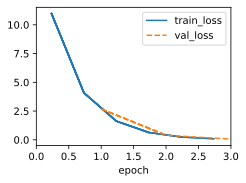

In [9]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Because we synthesized the dataset ourselves,
we know precisely what the true parameters are.
Thus, we can [**evaluate our success in training
by comparing the true parameters
with those that we learned**] through our training loop.
Indeed they turn out to be very close to each other.

데이터 세트를 직접 합성했기 때문에
실제 매개변수가 무엇인지 정확히 알고 있습니다.따라서 훈련 루프를 통해 [**실제 매개변수와
학습한 매개변수를 비교하여** 훈련 성공 여부를 평가할 수 있습니다.]
실제로 두 매개변수는 서로 매우 가까운 것으로 나타났습니다.


In [10]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.1023, -0.1993])
error in estimating b: tensor([0.2442])


We should not take the ability to exactly recover 
the ground truth parameters for granted.
In general, for deep models unique solutions
for the parameters do not exist,
and even for linear models,
exactly recovering the parameters
is only possible when no feature 
is linearly dependent on the others.
However, in machine learning, 
we are often less concerned
with recovering true underlying parameters,
but rather with parameters 
that lead to highly accurate prediction :cite:`Vapnik.1992`.
Fortunately, even on difficult optimization problems,
stochastic gradient descent can often find remarkably good solutions,
owing partly to the fact that, for deep networks,
there exist many configurations of the parameters
that lead to highly accurate prediction.


## Summary

In this section, we took a significant step 
towards designing deep learning systems 
by implementing a fully functional 
neural network model and training loop.
In this process, we built a data loader, 
a model, a loss function, an optimization procedure,
and a visualization and monitoring tool. 
We did this by composing a Python object 
that contains all relevant components for training a model. 
While this is not yet a professional-grade implementation
it is perfectly functional and code like this 
could already help you to solve small problems quickly.
In the coming sections, we will see how to do this
both *more concisely* (avoiding boilerplate code)
and *more efficiently* (using our GPUs to their full potential).

실제 매개변수를 정확하게 복구하는 능력을 당연하게 여겨서는 안 됩니다.일반적으로 심층 모델의 경우 매개변수에 대한 고유한 해는 존재하지 않으며, 선형 모델의 경우에도 매개변수를 정확하게 복구하는 것은 어떤 특징도 다른 특징에 선형적으로 종속되지 않을 때만 가능합니다.그러나 머신 러닝에서는 실제 기본 매개변수를 복구하는 것보다는 매우 정확한 예측으로 이어지는 매개변수에 더 관심을 두는 경우가 많습니다.(:cite:`Vapnik.1992`) 다행히도 어려운 최적화 문제에서도 확률적 경사 하강법은 매우 좋은 해를 찾을 수 있습니다. 이는 심층 네트워크의 경우 매우 정확한 예측으로 이어지는 다양한 매개변수 구성이 존재하기 때문입니다.## 요약

이 섹션에서는 완전히 기능하는 신경망 모델과 학습 루프를 구현하여 심층 학습 시스템을 설계하는 데 중요한 진전을 이루었습니다.이 과정에서 데이터 로더, 모델, 손실 함수, 최적화 절차, 그리고 시각화 및 모니터링 도구를 구축했습니다.모델 학습에 필요한 모든 구성 요소를 포함하는 Python 객체를 구성하여 이를 구현했습니다.아직 전문가 수준의 구현은 아니지만, 완벽하게 작동하며 이러한 코드는 작은 문제를 빠르게 해결하는 데 도움이 될 수 있습니다.다음 섹션에서는 이 작업을
*더 간결하게*(보일러플레이트 코드 사용 방지)
*더 효율적으로*(GPU의 성능을 최대한 활용하는 방법) 두 가지 방식으로 수행하는 방법을 살펴보겠습니다.



## Exercises

## 연습 문제

1. What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we
   initialized the parameters with variance $1000$ rather than $0.01$?
1. 가중치를 0으로 초기화하면 어떻게 될까요?알고리즘은 여전히 작동할까요?매개 변수를 분산 0.01이 아닌 1000으로 초기화하면 어떨까요?

가중치를 0으로 초기화하거나 분산이 너무 큰 값으로 초기화하면 알고리즘이 제대로 작동하지 않거나 성능이 저하될 수 있습니다.

---

## 가중치를 0으로 초기화하는 경우

가중치를 모두 0으로 초기화하면 **신경망이 학습할 수 없게 됩니다.** 그 이유는 다음과 같습니다.

* **대칭성 문제**: 모든 가중치가 동일하게 0으로 시작하면, 각 뉴런은 입력에 대해 동일한 기여를 하고 동일한 업데이트를 받게 됩니다. 즉, 모든 뉴런이 동일한 특성을 학습하려고 시도하게 되어 서로 다른 기능을 수행하도록 분화될 수 없습니다. 결과적으로, 신경망의 여러 뉴런이 실제로는 하나의 뉴런처럼 행동하게 되어 네트워크의 표현력을 크게 저하시킵니다.
* **경사 하강법의 실패**: 역전파 과정에서 가중치 업데이트는 이전 층의 활성화 값과 현재 층의 오차 기여도에 따라 이루어집니다. 가중치가 모두 0이면, 모든 뉴런의 출력은 활성화 함수에 따라 0 또는 동일한 상수가 되므로, 오차 기울기(gradient) 또한 모든 가중치에 대해 동일하게 계산됩니다. 이는 가중치가 서로 다른 방향으로 업데이트될 기회를 없애고, 학습이 멈추거나 매우 느리게 진행되게 만듭니다.

---

## 분산 1000으로 매개변수를 초기화하는 경우 (0.01 대신)

가중치를 0.01과 같은 작은 분산이 아닌 **1000과 같은 매우 큰 분산으로 초기화하면 여러 가지 문제가 발생할 수 있습니다.**

* **큰 초기 출력 값**: 가중치가 매우 크면, 신경망의 각 뉴런에서 계산되는 **초기 출력 값($\sum w_i x_i + b$)도 매우 커질 가능성이 높습니다.**
* **활성화 함수의 포화**: 시그모이드(sigmoid)나 tanh와 같은 비선형 활성화 함수는 입력 값이 매우 크거나 작을 때 **포화(saturation)되는 경향**이 있습니다.
    * 예를 들어, 시그모이드 함수는 입력이 $\pm$ 몇몇 값 이상이 되면 출력이 0 또는 1에 매우 가까워져 기울기가 거의 0이 됩니다.
    * 기울기가 0에 가까워지면 역전파 시 가중치 업데이트에 사용되는 **기울기 소실(vanishing gradient) 문제**가 발생하여 학습이 매우 느려지거나 멈추게 됩니다.
* **불안정한 학습**: 가중치가 너무 크면 작은 입력 변화에도 출력 값이 크게 변동할 수 있어 **학습 과정이 매우 불안정해질 수 있습니다.** 이는 손실 함수가 발산하거나 최적점을 찾기 어렵게 만들 수 있습니다.
* **오버피팅 가능성 증가**: 너무 큰 가중치는 모델이 훈련 데이터의 노이즈까지 학습하여 **오버피팅될 위험을 높입니다.** 이는 일반화 성능을 저하시킵니다.

---

## 결론

두 경우 모두 신경망의 효과적인 학습을 방해합니다. 따라서 가중치 초기화는 신경망 학습의 성공에 매우 중요한 요소이며, 일반적으로 **작고 무작위적인 값(예: He 초기화, Xavier 초기화 등)**으로 초기화하여 위에서 언급된 문제들을 피하면서 학습 초기 단계에서 적절한 기울기를 유지하도록 합니다.


1. Assume that you are [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm) trying to come up
   with a model for resistance that relates voltage and current. Can you use automatic
   differentiation to learn the parameters of your model?
1. [게오르크 시몬 옴](https://en.wikipedia.org/wiki/Georg_Ohm)이 전압과 전류를 연관시키는 저항 모델을 고안하려고 한다고 가정해 보겠습니다. 자동 미분을 사용하여 모델의 매개변수를 학습할 수 있습니까?

전압과 전류를 연관시키는 저항 모델을 개발하려는 게오르크 옴이라고 가정해 볼 때, **자동 미분을 사용하여 모델의 매개변수를 학습할 수는 없습니다.** 😥 그 이유는 다음과 같습니다.

---

## 자동 미분과 옴의 법칙

자동 미분은 복잡한 함수의 기울기를 효율적으로 계산하는 기술로, 주로 **머신러닝 모델의 매개변수를 최적화하는 데 사용**됩니다. 모델이 예측하는 값과 실제 값 사이의 오차를 정의하는 손실 함수가 있을 때, 자동 미분은 이 손실 함수를 모델의 매개변수에 대해 미분하여, 매개변수를 어떤 방향으로 조정해야 오차가 줄어들지 알려줍니다.

하지만 옴의 법칙(Ohm's Law)은 $V = IR$이라는 **고정된 물리 법칙**입니다.

* **$V$**: 전압 (Voltage)
* **$I$**: 전류 (Current)
* **$R$**: 저항 (Resistance)

이 모델에는 **학습할 '매개변수'가 없습니다.** $R$은 우리가 "학습"해야 할 변수가 아니라, 특정 도체에 대한 **고유한 특성 값**입니다. 만약 우리가 여러 전압($V$)과 전류($I$) 측정값을 가지고 $R$ 값을 찾아내려 한다면, 이는 단순히 **대수적으로 $R = V/I$를 계산**하는 문제입니다.

---

## 왜 자동 미분이 필요 없는가?

자동 미분은 주로 다음과 같은 상황에서 유용합니다.

1.  **복잡한 비선형 관계**: 신경망과 같이 입력과 출력 사이에 복잡한 비선형 관계가 있을 때.
2.  **수많은 매개변수**: 수백만 개의 매개변수를 가진 모델에서 각 매개변수에 대한 기울기를 효율적으로 계산해야 할 때.
3.  **최적화**: 손실 함수를 최소화하기 위해 반복적으로 매개변수를 조정하는 최적화 알고리즘(예: 경사 하강법)을 사용할 때.

옴의 법칙은 이 세 가지 조건 중 어느 것에도 해당하지 않습니다. $R$은 하나의 단일 값이며, 그 관계는 단순한 선형 방정식입니다. 따라서 자동 미분이라는 복잡한 도구를 사용할 필요가 전혀 없습니다. 측정된 전압과 전류 값을 사용하여 단순히 나누기만 하면 저항($R$) 값을 바로 얻을 수 있습니다.

**결론적으로, 옴의 법칙과 같은 단순한 물리 모델의 경우, 자동 미분은 필요하지 않으며 적용하는 것도 적절하지 않습니다.** 😅


1. Can you use [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object
   using spectral energy density? For reference, the spectral density $B$ of radiation emanating from a black body is
   $B(\lambda, T) = \frac{2 hc^2}{\lambda^5} \cdot \left(\exp \frac{h c}{\lambda k T} - 1\right)^{-1}$. Here
   $\lambda$ is the wavelength, $T$ is the temperature, $c$ is the speed of light, $h$ is Planck's constant, and $k$ is the
   Boltzmann constant. You measure the energy for different wavelengths $\lambda$ and you now need to fit the spectral
   density curve to Planck's law.

1. [플랑크의 법칙](https://en.wikipedia.org/wiki/Planck%27s_law)을 사용하여 스펙트럼 에너지 밀도를 사용하여 물체의 온도를 결정할 수 있습니까?참고로, 흑체에서 나오는 복사의 스펙트럼 밀도 $B$는
$B(\lambda, T) = \frac{2 hc^2}{\lambda^5} \cdot \left(\exp \frac{h c}{\lambda k T} - 1\right)^{-1}$입니다.여기서
$\lambda$는 파장, $T$는 온도, $c$는 빛의 속도, $h$는 플랑크 상수, $k$는 볼츠만 상수입니다.다양한 파장 $\lambda$에 대한 에너지를 측정하고 이제 스펙트럼 밀도 곡선을 플랑크 법칙에 맞춰야 합니다.

네, **플랑크 법칙**을 사용하여 스펙트럼 에너지 밀도를 통해 물체의 온도를 결정할 수 있습니다. 🌡️

---

## 플랑크 법칙을 이용한 온도 결정

측정된 다양한 파장($\lambda$)에 대한 스펙트럼 에너지 밀도($B$) 데이터를 가지고 있다면, 주어진 플랑크 법칙 방정식에 데이터를 **피팅(fitting)**하여 물체의 온도를 추정할 수 있습니다. 이는 역 문제(inverse problem)에 해당하며, 측정된 데이터에 가장 잘 맞는 $T$ 값을 찾는 과정입니다.

플랑크 법칙은 다음과 같습니다:
$$B(\lambda, T) = \frac{2 hc^2}{\lambda^5} \cdot \left(\exp \frac{h c}{\lambda k T} - 1\right)^{-1}$$
여기서 $c$, $h$, $k$는 모두 **상수**입니다.

### 1. 데이터 수집
먼저, 다양한 파장 $\lambda_1, \lambda_2, \ldots, \lambda_n$에 해당하는 스펙트럼 에너지 밀도 $B_1, B_2, \ldots, B_n$를 측정합니다.

### 2. 최적화 문제 정의
우리의 목표는 측정된 $B_{measured}(\lambda)$ 값과 플랑크 법칙에 의해 예측된 $B(\lambda, T)$ 값 사이의 **오차를 최소화하는 온도 $T$를 찾는 것**입니다. 이를 위해 **손실 함수(loss function)**를 정의할 수 있습니다. 일반적인 손실 함수는 다음과 같습니다:

$$L(T) = \sum_{i=1}^{n} (B_{measured}(\lambda_i) - B(\lambda_i, T))^2$$

이것은 **최소 제곱법(least squares method)**의 한 형태입니다. 오차를 최소화하는 $T$를 찾으면, 그 $T$가 해당 물체의 온도가 됩니다.

### 3. 최적화 방법
이 손실 함수를 최소화하는 $T$를 찾기 위해 **비선형 회귀(nonlinear regression)** 기법을 사용할 수 있습니다. 몇 가지 일반적인 접근 방식은 다음과 같습니다:

* **수치 최적화**: 경사 하강법(gradient descent)과 같은 반복적인 최적화 알고리즘을 사용하여 손실 함수의 기울기를 따라 $T$를 점진적으로 조정하여 최소값을 찾습니다. 이 과정에서 $L(T)$를 $T$에 대해 미분할 필요가 있으며, **자동 미분(automatic differentiation)**과 같은 기술이 유용하게 사용될 수 있습니다.
* **특정 파장 이용**:
    * **빈의 변위 법칙(Wien's Displacement Law)**: 플랑크 곡선은 특정 온도에서 최대 방출을 보이는 파장($\lambda_{max}$)을 가집니다. 빈의 변위 법칙은 이 최대 파장과 온도가 반비례 관계에 있음을 나타냅니다: $\lambda_{max} T = b$ (여기서 $b$는 빈의 상수). 만약 스펙트럼에서 최대 에너지 밀도를 보이는 파장을 정확히 측정할 수 있다면, $T = b / \lambda_{max}$ 공식을 사용하여 온도를 직접 추정할 수 있습니다. 이는 플랑크 곡선 전체를 피팅하는 것보다 간단할 수 있지만, $\lambda_{max}$를 정확히 식별해야 합니다.
    * **슈테판-볼츠만 법칙(Stefan-Boltzmann Law)**: 모든 파장에 걸쳐 방출되는 총 에너지(또는 파장 적분)는 온도의 4제곱에 비례합니다. 이 방법을 사용하려면 전체 스펙트럼에 걸쳐 통합된 에너지를 측정해야 합니다.

### 4. 실제 적용 시 고려사항
* **이상적인 흑체 가정**: 플랑크 법칙은 **이상적인 흑체(black body)**에 대해 정의됩니다. 실제 물체는 완벽한 흑체가 아니므로, 방사율(emissivity)이라는 요소를 고려해야 합니다. 방사율은 물체가 이상적인 흑체에 비해 얼마나 많은 에너지를 방출하는지를 나타내며, 일반적으로 0과 1 사이의 값을 가집니다.
* **측정 오차**: 스펙트럼 에너지 밀도 측정에는 항상 오차가 수반됩니다. 이러한 오차는 $T$ 추정치의 정확도에 영향을 미칠 수 있습니다.
* **비선형 피팅 소프트웨어**: Python의 `scipy.optimize.curve_fit`이나 MATLAB의 `fit` 함수와 같은 라이브러리를 사용하면 비선형 모델을 데이터에 쉽게 피팅할 수 있습니다.

요약하자면, 플랑크 법칙은 주어진 스펙트럼 에너지 밀도 데이터에 대해 **온도 $T$를 유일한 미지수로 두고 최적화 문제를 해결함으로써 물체의 온도를 결정하는 데 사용될 수 있습니다.**



1. What are the problems you might encounter if you wanted to compute the second derivatives of the loss? How would
   you fix them?
1. 손실의 2차 미분을 계산할 때 발생할 수 있는 문제는 무엇입니까?어떻게 해결하시겠습니까?

손실 함수의 2차 미분(헤세 행렬)을 계산하려고 할 때 발생할 수 있는 주요 문제점은 **계산 비용과 메모리 요구 사항**입니다. 이를 해결하기 위한 여러 접근 방식이 있습니다.

---

## 2차 미분 계산 시 문제점

### 1. **계산 복잡성 (Computational Complexity)**
* 모델 매개변수 수가 $N$개일 때, 헤세 행렬은 $N \times N$ 크기를 가집니다. 따라서 $N^2$개의 2차 편미분을 계산해야 합니다.
* 신경망과 같이 매개변수 수가 수백만 개에 달하는 모델에서는 $N^2$는 엄청나게 큰 숫자가 됩니다. 예를 들어, 100만 개의 매개변수를 가진 모델의 경우 헤세 행렬은 $10^{12}$개의 요소를 가집니다. 각 요소를 계산하는 데 드는 비용은 **막대합니다.**

### 2. **메모리 요구 사항 (Memory Requirements)**
* 헤세 행렬을 명시적으로 저장하려면 $N^2$개의 요소를 저장할 공간이 필요합니다. 위와 같은 100만 개 매개변수 모델의 경우, 이는 **테라바이트(TB) 단위의 메모리**를 필요로 할 수 있어 실용적이지 않습니다.

### 3. **희소성 문제 (Sparsity Issues)**
* 경우에 따라 헤세 행렬이 희소(sparse)할 수 있지만, 딥러닝 모델에서는 일반적으로 **밀집(dense) 행렬**이므로 희소 행렬의 장점을 활용하기 어렵습니다.

---

## 해결 방법

이러한 문제점을 해결하기 위해 다음과 같은 방법들이 사용됩니다.

### 1. **헤세 행렬-벡터 곱 사용 (Hessian-Vector Products)**
* **아이디어**: 전체 헤세 행렬을 명시적으로 계산하거나 저장하는 대신, 필요한 경우 **헤세 행렬과 벡터의 곱($H v$)만을 계산**합니다.
* **장점**: 이는 역전파와 유사한 방식으로 효율적으로 계산할 수 있으며, 계산 복잡성이 $O(N^2)$ 대신 $O(N)$ 또는 $O(N \cdot (\text{한 번의 역전파 비용}))$으로 줄어듭니다.
* **활용**: 뉴턴 방법(Newton's method)의 변형인 **준-뉴턴 방법(Quasi-Newton methods)** (BFGS, L-BFGS 등)에서 사용됩니다. 이들은 2차 정보를 직접적으로 사용하지 않고, 1차 미분(그래디언트)의 변화를 통해 헤세 행렬의 역행렬을 **근사(approximate)**합니다.

### 2. **제한된 메모리 준-뉴턴 방법 (Limited-memory Quasi-Newton Methods, L-BFGS)**
* **아이디어**: BFGS와 같은 준-뉴턴 방법의 메모리 요구 사항을 줄인 버전입니다. 과거 그래디언트 정보의 일부만을 저장하여 헤세 행렬의 역행렬을 근사합니다.
* **장점**: 대규모 문제에서도 적용 가능하며, 풀 배치(full-batch) 학습 시 효과적입니다.
* **한계**: 미니배치 경사 하강법(mini-batch gradient descent)에서는 그래디언트의 노이즈 때문에 성능이 저하될 수 있습니다.

### 3. **가우시안-뉴턴 행렬 또는 Fisher 정보 행렬 사용 (Gaussian-Newton or Fisher Information Matrix)**
* **아이디어**: 특정 유형의 손실 함수(예: 최소 제곱 오차)에 대해 헤세 행렬은 **가우시안-뉴턴 행렬**로 근사될 수 있습니다. 분류 문제에서는 **Fisher 정보 행렬**이 헤세 행렬의 기댓값과 관련되어 사용될 수 있습니다.
* **장점**: 이들 행렬은 항상 양의 준정부호(positive semi-definite)이므로 최적화 과정이 더 안정적일 수 있습니다. 또한, 계산이 더 간단할 수 있습니다.
* **활용**: 자연 경사 하강법(Natural Gradient Descent) 등에서 사용됩니다.

### 4. **부분적인 2차 정보 사용 (Partial Second-Order Information)**
* **아이디어**: 전체 헤세 행렬 대신, **대각 성분(diagonal entries)**만 계산하거나, **블록 대각선(block-diagonal) 근사**를 사용합니다.
* **장점**: 계산 및 저장 비용이 크게 줄어듭니다.
* **활용**: AdamW와 같은 일부 최적화 알고리즘은 2차 모멘트(제곱 그래디언트)의 지수 이동 평균을 사용하여 **어댑티브(adaptive) 학습률**을 조정하는데, 이는 헤세 행렬의 대각 근사와 유사한 효과를 가집니다.

### 5. **자동 미분의 효율적 활용 (Efficient Use of Automatic Differentiation)**
* **아이디어**: 현대 딥러닝 프레임워크(TensorFlow, PyTorch 등)의 자동 미분 기능은 1차 미분뿐만 아니라 2차 미분도 효율적으로 계산할 수 있도록 설계되어 있습니다 (예: `torch.autograd.grad(..., create_graph=True)`).
* **장점**: 수동 미분 구현의 오류를 줄이고 복잡한 계산 그래프에서도 미분을 정확하게 수행합니다.
* **한계**: 여전히 위에서 언급한 계산 복잡성 및 메모리 문제는 해결되지 않습니다. 효율적인 계산은 **헤세 행렬-벡터 곱**과 같은 방식을 지원하는 데 더 초점을 맞춥니다.

---

요약하자면, 손실 함수의 2차 미분 계산은 계산 비용과 메모리 요구 사항 때문에 비현실적일 수 있습니다. 이를 해결하기 위해 우리는 **헤세 행렬 자체를 계산하는 대신 헤세 행렬-벡터 곱을 사용하거나, 헤세 행렬을 근사하는 방법(준-뉴턴 방법, Fisher 정보 행렬)을 사용**하여 이점을 얻습니다. 이는 특히 대규모 딥러닝 모델에서 최적화 알고리즘의 효율성을 높이는 데 중요합니다.


1. Why is the `reshape` method needed in the `loss` function?
1. `loss` 함수에 `reshape` 메서드가 필요한 이유는 무엇입니까?

`loss` 함수에서 `reshape` 메서드가 필요한 이유는 주로 **데이터의 차원을 손실 함수의 입력 요구사항에 맞추거나, 계산의 일관성을 유지하고 브로드캐스팅 오류를 방지하기 위해서**입니다. 📉

-----

## `reshape` 메서드가 필요한 이유

### 1\. 차원 불일치 해결

손실 함수는 일반적으로 **특정 차원(shape)의 입력**을 기대합니다. 예를 들어:

  * **예측값과 실제값의 비교**: 대부분의 손실 함수는 예측값과 실제값이 동일한 차원이어야 한다고 가정합니다. 모델의 출력 차원이나 레이블 데이터의 차원이 손실 함수가 예상하는 차원과 다를 때, `reshape`을 통해 이를 맞춰줍니다.
  * **배치 처리**: 딥러닝 모델은 보통 데이터를 **배치(batch)** 단위로 처리합니다. `reshape`은 단일 샘플의 예측 결과나 레이블을 배치 차원에 맞게 확장하거나, 반대로 특정 계산을 위해 배치 차원을 제거할 때 사용될 수 있습니다.

### 2\. 브로드캐스팅 오류 방지

넘파이(NumPy)나 파이토치(PyTorch), 텐서플로우(TensorFlow)와 같은 라이브러리들은 **브로드캐스팅(broadcasting)** 기능을 제공하여 서로 다른 차원의 배열 간 연산을 가능하게 합니다. 하지만 두 배열의 차원이 브로드캐스팅 규칙에 맞지 않을 경우 **오류가 발생**합니다. `reshape`은 이러한 브로드캐스팅 오류를 피하고 연산이 가능하도록 명시적으로 차원을 조정하는 데 사용됩니다.

예를 들어, `(N,)` 형태의 1차원 배열(N개의 요소를 가진 벡터)과 `(N, 1)` 형태의 2차원 배열(N개의 행과 1개의 열을 가진 행렬)은 값이 같아 보일 수 있지만, 파이썬이나 기타 머신러닝 프레임워크에서는 **서로 다른 차원**으로 인식됩니다. 이 두 배열을 특정 연산에 사용하면 브로드캐스팅 문제가 발생할 수 있습니다. `reshape(-1, 1)`이나 `reshape(1, -1)`과 같은 작업은 이러한 차이를 명확히 하여 연산이 제대로 수행되도록 돕습니다.

### 3\. 단일 값 처리의 일관성

때로는 모델이 하나의 스칼라 값(예: 회귀 문제의 단일 예측값)을 출력하거나, 레이블이 단일 값으로 제공될 수 있습니다. 하지만 손실 함수는 이러한 단일 값을 `(1,)` 또는 `(1, 1)`과 같은 특정 차원의 텐서로 기대할 수 있습니다. 이 경우 `reshape`을 통해 **단일 값을 배치 차원이 있는 텐서 형태로 변환**하여 손실 함수와의 호환성을 맞춥니다.

-----

## 예시

**스칼라 예측값을 `(배치 크기, 1)` 형태로 맞추기:**

모델이 배치 크기 $M$에 대해 $M$개의 스칼라 값을 예측한다고 가정해 봅시다. 이 예측값들은 `(M,)` 형태의 1차원 배열로 나올 수 있습니다. 하지만 손실 함수(예: 평균 제곱 오차)는 예측값과 실제값을 `(M, 1)` 형태의 2차원 배열로 기대할 수 있습니다. 이 경우 `reshape(-1, 1)`을 사용하여 차원을 맞춰줍니다.

```python
import numpy as np

predictions = np.array([0.5, 0.2, 0.8]) # 예측값, shape: (3,)
true_labels = np.array([0.6, 0.3, 0.7]) # 실제값, shape: (3,)

# 만약 손실 함수가 (batch_size, 1) 형태를 기대한다면:
predictions_reshaped = predictions.reshape(-1, 1) # shape: (3, 1)
true_labels_reshaped = true_labels.reshape(-1, 1) # shape: (3, 1)

print(f"변환 전 예측값 차원: {predictions.shape}")
print(f"변환 후 예측값 차원: {predictions_reshaped.shape}")

# 이제 손실 함수에 전달하여 계산 가능
# loss = some_loss_function(predictions_reshaped, true_labels_reshaped)
```

이처럼 `reshape`은 데이터의 **형태를 명시적으로 제어**하여 손실 함수가 올바르게 작동하고 예측값과 실제값 간의 비교가 정확히 이루어지도록 돕는 필수적인 작업입니다.


1. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the
   error by increasing the number of epochs of training?

1. 다양한 학습률을 사용하여 손실 함수 값이 얼마나 빨리 감소하는지 실험해 보십시오.학습 에포크 수를 늘려 오류를 줄일 수 있습니까?

네, 학습률을 다르게 설정하여 손실 함수 값의 감소 속도를 실험할 수 있습니다. 또한, 일반적으로는 훈련 epoch 수를 늘림으로써 오차를 줄일 수 있습니다.

---

## 학습률과 손실 함수의 관계 실험 🧪

**학습률(Learning Rate)**은 경사 하강법과 같은 최적화 알고리즘에서 **매개변수를 얼마나 크게 업데이트할지 결정하는 스텝 크기**를 나타냅니다. 학습률을 다르게 설정하면 손실 함수가 최소값으로 수렴하는 속도와 최종 도달하는 최소값에 큰 영향을 미칩니다.

### 실험 방법
1.  **모델 및 데이터셋 준비**: 동일한 신경망 모델과 훈련/검증 데이터셋을 준비합니다.
2.  **다양한 학습률 설정**: 0.1, 0.01, 0.001, 0.0001 등 여러 학습률 값을 선택합니다.
3.  **훈련 수행**: 각 학습률에 대해 동일한 epoch 수(예: 50~100 epoch)로 모델을 훈련시킵니다.
4.  **손실 값 기록**: 각 epoch마다 훈련 손실(training loss)과 검증 손실(validation loss) 값을 기록합니다.
5.  **결과 시각화 및 분석**:
    * **손실 곡선 플로팅**: x축을 epoch, y축을 손실 값으로 하여 각 학습률별 손실 곡선을 그립니다.
    * **너무 높은 학습률**: 손실 값이 발산하거나(무한대로 증가), 큰 폭으로 요동치면서 제대로 수렴하지 못할 수 있습니다. 최적점을 건너뛰기 때문입니다.
    * **너무 낮은 학습률**: 손실 값이 매우 느리게 감소하고, 훈련 시간이 오래 걸립니다. 지역 최적점(local minimum)에 갇힐 가능성이 높아집니다.
    * **적절한 학습률**: 손실 값이 안정적으로 빠르게 감소하며, 낮은 최소값에 수렴하는 것을 볼 수 있습니다.

**예시 시나리오:**
* **학습률 = 0.1**: 손실이 빠르게 감소하지만, 어느 시점부터는 감소하지 않고 크게 요동치거나 발산할 수 있습니다.
* **학습률 = 0.01**: 손실이 안정적으로 감소하며, 0.1보다는 느리지만 더 낮은 최종 손실 값에 도달할 수 있습니다.
* **학습률 = 0.001**: 손실이 0.01보다 더 느리게 감소하지만, 더 안정적이고 미세 조정이 잘되어 더 낮은 최종 손실 값에 도달할 수도 있습니다. 너무 낮으면 정체될 수 있습니다.

---

## 훈련 Epoch 수 증가를 통한 오차 감소 📉

**훈련 epoch 수**를 늘리는 것은 모델이 훈련 데이터로부터 학습할 기회를 더 많이 제공하므로, **일반적으로는 오차를 줄이는 데 도움이 됩니다.** 모델은 각 epoch마다 전체 훈련 데이터를 한 번씩 보고 가중치를 업데이트합니다.

### 긍정적 측면
* **수렴**: 더 많은 epoch를 통해 모델은 손실 함수의 전역 또는 지역 최소값에 더 가까이 수렴할 시간을 갖게 됩니다.
* **성능 향상**: 훈련 데이터에 대한 모델의 이해도가 깊어져 훈련 오차가 줄어들고, 일반적으로 검증 오차(일반화 성능)도 개선됩니다.

### 주의할 점: 과적합 (Overfitting) ⚠️
하지만 훈련 epoch 수를 **무한정 늘린다고 해서 항상 좋은 결과를 얻는 것은 아닙니다.** 특정 시점을 넘어서면 **과적합(overfitting)** 문제가 발생할 수 있습니다.

* **과적합 발생**: 모델이 훈련 데이터를 너무 '외워버려서' 훈련 오차는 계속 줄어들지만, 한 번도 보지 못한 새로운 데이터(검증/테스트 데이터)에 대한 오차(일반화 오차)는 오히려 증가하기 시작합니다.
* **조기 종료 (Early Stopping)**: 과적합을 방지하기 위한 일반적인 전략은 **조기 종료**입니다. 훈련 중 검증 손실이 더 이상 개선되지 않고 오히려 증가하기 시작하는 시점에서 훈련을 멈추는 것입니다. 이를 통해 모델이 최적의 일반화 성능을 가질 때의 가중치를 얻을 수 있습니다.

---

**결론적으로,** 다양한 학습률을 실험하여 가장 효율적으로 손실을 줄이는 학습률을 찾을 수 있으며, 훈련 epoch 수를 늘림으로써 모델의 성능을 향상시킬 수 있지만, 과적합을 방지하기 위해 검증 손실을 모니터링하며 적절한 시점에서 훈련을 멈추는 것이 중요합니다.



1. If the number of examples cannot be divided by the batch size, what happens to `data_iter` at the end of an epoch?
1. 예제 수를 배치 크기로 나눌 수 없는 경우, 에포크가 끝날 때 `data_iter`는 어떻게 됩니까?

샘플 수가 배치 크기로 나누어 떨어지지 않을 경우, `data_iter`의 마지막 배치는 **남은 샘플들로 구성**됩니다. 즉, 마지막 배치의 크기가 일반적으로 설정된 배치 크기보다 **작아집니다.**

---

## `data_iter`의 마지막 배치 처리 방식

대부분의 딥러닝 프레임워크(예: PyTorch의 `DataLoader`, TensorFlow의 `tf.data`)에서 데이터를 배치 단위로 나누어 이터레이터(`data_iter`)를 생성할 때, 전체 샘플 수가 배치 크기로 나누어 떨어지지 않으면 다음과 같이 처리됩니다:

1.  **나머지 샘플로 구성**: 예를 들어, 총 100개의 샘플이 있고 배치 크기가 16이라고 가정해 봅시다.
    * 첫 6개 배치는 각각 16개의 샘플을 가집니다 (16 * 6 = 96).
    * 마지막 7번째 배치는 남은 4개의 샘플(100 - 96 = 4)로만 구성됩니다. 따라서 이 배치의 크기는 4가 됩니다.

이는 **데이터 손실을 방지**하면서 모든 샘플이 한 에포크 동안 최소 한 번은 모델 훈련에 사용되도록 하기 위함입니다.

---

## 훈련에 미치는 영향

마지막 배치의 크기가 작아지는 것은 훈련 과정에 다음과 같은 영향을 미칠 수 있습니다:

* **배치 정규화(Batch Normalization)의 영향**: 배치 정규화를 사용하는 모델의 경우, 마지막 배치의 통계량(평균, 분산)은 다른 큰 배치들에 비해 **덜 신뢰할 수 있습니다.** 이는 배치 크기가 작을수록 통계량 추정의 노이즈가 커지기 때문입니다. 하지만 일반적으로 이 영향은 미미하며, 전체 훈련 과정에 큰 문제를 일으키지는 않습니다.
* **경사 하강법 업데이트의 불안정성**: 작은 배치에서는 그래디언트(기울기) 계산이 더 불안정하고 노이즈가 많을 수 있습니다. 그러나 전체 에포크 동안 이 작은 배치가 차지하는 비중이 크지 않으므로, 이 또한 전반적인 훈련 안정성에 큰 영향을 주지는 않습니다.

대부분의 경우, 이러한 마지막 배치 처리 방식은 표준이며 특별히 문제가 되지 않습니다. 만약 이 부분이 훈련에 문제가 될 정도로 중요하다고 판단된다면, `drop_last=True`와 같은 옵션을 사용하여 마지막으로 남은 불완전한 배치를 아예 **버리도록(drop)** 설정할 수도 있습니다. 하지만 이 경우 몇 개의 샘플이 훈련에 사용되지 않을 수 있습니다.


1. Try implementing a different loss function, such as the absolute value loss `(y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()`.
    1. Check what happens for regular data.
    1. Check whether there is a difference in behavior if you actively perturb some entries, such as $y_5 = 10000$, of $\mathbf{y}$.
    1. Can you think of a cheap solution for combining the best aspects of squared loss and absolute value loss?
       Hint: how can you avoid really large gradient values?
1. 절댓값 손실 함수 `(y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()`과 같은 다른 손실 함수를 구현해 보세요
   1. 일반 데이터에서 어떤 일이 일어나는지 확인하세요.
   1. $\mathbf{y}$의 $y_5 = 10000$과 같은 일부 항목을 적극적으로 교란했을 때 동작에 차이가 있는지 확인하세요.
   1. 제곱 손실과 절댓값 손실의 장점을 결합하는 저렴한 해결책을 생각해 볼 수 있나요?힌트: 매우 큰 기울기 값을 어떻게 방지할 수 있나요?

L1 손실(절대값 손실)을 구현하고, 특이값 존재 시의 동작 차이를 확인하며, L1 및 L2 손실의 장점을 결합하는 방법에 대해 알아보겠습니다.

---

## 1. 정규 데이터에 대한 L1 손실 (Absolute Value Loss) 동작 확인 📏

L1 손실 함수는 예측값($\hat{y}$)과 실제값($y$) 사이의 **절대 오차의 합**으로 정의됩니다.
$$L_1(\hat{y}, y) = \sum_{i=1}^{n} |\hat{y}_i - y_i|$$

**특징:**
* **견고성(Robustness)**: 이상치(outliers)에 덜 민감합니다. 이는 오차가 선형적으로 반영되기 때문에, 큰 오차가 발생하더라도 제곱 오차($L_2$)처럼 극단적으로 커지지 않기 때문입니다.
* **불연속적인 기울기**: $0$에서 미분 불가능합니다. $\hat{y}_i = y_i$일 때 기울기가 정의되지 않습니다.
* **수렴**: 최적점에서 기울기가 $0$이 아닌 상수값을 가질 수 있어, 제곱 손실보다 최적점에 도달하는 데 더 많은 시간이 걸리거나 진동할 수 있습니다.

**정규 데이터에 대한 동작:**
정규 분포를 따르거나 이상치가 없는 깨끗한 데이터의 경우, L1 손실은 L2 손실(평균 제곱 오차)과 유사하게 작동합니다. 손실 값은 예측이 실제 값에 가까워질수록 감소하며, 모델은 데이터의 중앙 경향을 잘 포착하려고 합니다. 하지만 L2 손실보다 수렴 속도가 약간 느리거나 최적점 근처에서 진동하는 경향을 보일 수 있습니다.

---

## 2. 특정 엔트리를 교란했을 때의 동작 차이 확인 ($y_5 = 10000$) 💥

실제 값 $y$의 특정 항목($y_5 = 10000$)을 크게 교란했을 때, L1 손실과 L2 손실은 매우 다른 동작을 보입니다.

* **L2 손실 (Mean Squared Error)**:
    $$L_2(\hat{y}, y) = \sum_{i=1}^{n} (\hat{y}_i - y_i)^2$$
    하나의 큰 이상치($y_5 = 10000$)는 $(\hat{y}_5 - 10000)^2$ 항을 통해 **손실 값에 매우 큰 영향**을 미칩니다. 이 큰 오차는 제곱되어 손실 함수의 대부분을 차지하게 되고, 모델은 이 **이상치를 최소화하는 데 집중**하게 됩니다. 이는 다른 정상적인 데이터 포인트에 대한 예측 성능을 저하시킬 수 있습니다. 즉, L2 손실은 이상치에 매우 **민감**합니다.

* **L1 손실 (Absolute Error Loss)**:
    $$L_1(\hat{y}, y) = \sum_{i=1}^{n} |\hat{y}_i - y_i|$$
    동일한 이상치($y_5 = 10000$)가 있을 때, L1 손실은 $|\hat{y}_5 - 10000|$ 항으로 영향을 받습니다. 이 오차는 선형적으로 반영되므로, L2 손실의 제곱 항처럼 극단적으로 커지지 않습니다. 따라서 모델은 여전히 이 이상치에 반응하지만, **다른 정상적인 데이터 포인트에 대한 균형을 잃지 않고** 더 안정적인 예측을 시도합니다. L1 손실은 이상치에 대해 **더 견고**합니다.

**결론:** 특이값에 대해 L1 손실은 L2 손실보다 훨씬 **견고하며**, 이상치가 모델 학습을 지배하는 것을 방지합니다.

---

## 3. 제곱 손실과 절대값 손실의 장점을 결합하는 저비용 솔루션 (큰 기울기 값 회피) ⚖️

제곱 손실은 부드럽고 미분이 가능하여 최적화가 용이하지만 이상치에 민감하고, 절대값 손실은 이상치에 견고하지만 미분 불가능한 지점이 있습니다. 이 두 가지 손실 함수의 장점을 결합하고 큰 기울기 값을 피하는 저비용 솔루션은 바로 **Huber 손실(후버 손실)**입니다.

### Huber 손실 (Huber Loss)
Huber 손실은 특정 임계값($\delta$)을 기준으로 제곱 손실과 절대값 손실을 결합합니다.

$$
L_{\delta}(a) =
\begin{cases}
    \frac{1}{2}a^2 & \text{if } |a| \le \delta \\
    \delta (|a| - \frac{1}{2}\delta) & \text{if } |a| > \delta
\end{cases}
$$
여기서 $a = \hat{y} - y$는 오차입니다.

**작동 방식:**
* **작은 오차($|a| \le \delta$)**: 오차가 작은 경우(모델의 예측이 실제 값에 근접한 경우), Huber 손실은 **제곱 손실처럼 작동**합니다. 이는 손실 함수가 부드럽고 미분 가능하여 최적화가 용이하다는 L2 손실의 장점을 가져옵니다.
* **큰 오차($|a| > \delta$)**: 오차가 큰 경우(이상치에 의한 경우), Huber 손실은 **절대값 손실처럼 작동**합니다. 이는 큰 오차가 선형적으로 반영되므로 이상치에 덜 민감하고, L2 손실처럼 극단적으로 큰 기울기 값을 생성하여 최적화 과정을 방해하는 것을 방지합니다.

**큰 기울기 값 회피:**
Huber 손실은 큰 오차에 대해 제곱이 아닌 선형적으로 증가하기 때문에, 이상치로부터 발생하는 **매우 큰 기울기 값을 효과적으로 피할 수 있습니다.** 이는 학습 과정의 안정성을 높이고, 모델이 이상치에 의해 과도하게 영향을 받는 것을 방지합니다.

**장점 요약:**
* **견고성**: 이상치에 대해 L1 손실처럼 견고합니다.
* **부드러움**: $0$ 근처에서 L2 손실처럼 미분 가능하여 최적화가 더 안정적입니다.
* **제어 가능한 전환**: $\delta$ 값을 조절하여 제곱 손실에서 절대값 손실로 전환되는 지점을 제어할 수 있습니다.

Huber 손실은 회귀 문제에서 이상치가 있는 데이터셋에 특히 유용하며, 많은 머신러닝 라이브러리에서 기본적으로 제공됩니다.


1. Why do we need to reshuffle the dataset? Can you design a case where a maliciously constructed dataset would break the optimization algorithm otherwise?

1. 데이터셋을 재구성해야 하는 이유는 무엇인가요?악의적으로 구성된 데이터셋이 최적화 알고리즘을 손상시킬 수 있는 경우를 설계할 수 있나요?

데이터셋을 다시 섞는(reshuffle 또는 shuffle) 이유는 주로 **훈련 과정의 안정성과 일반화 성능을 향상시키기 위함**입니다. 악의적으로 구성된 데이터셋은 섞지 않으면 최적화 알고리즘을 망가뜨릴 수 있습니다.

---

## 데이터셋을 섞어야 하는 이유

1.  **배치 편향 방지**:
    * 신경망 훈련 시 데이터를 **배치(batch)** 단위로 나누어 학습합니다. 만약 데이터가 특정 순서로 정렬되어 있다면(예: 모든 긍정 리뷰가 먼저 나오고 그 다음에 모든 부정 리뷰가 나오는 경우), 각 배치는 특정 클래스나 특징만 포함하게 됩니다.
    * 이는 모델이 각 배치마다 매우 편향된 그래디언트(gradient)를 계산하게 하여, 가중치 업데이트가 특정 방향으로만 이루어지도록 만듭니다. 결과적으로 **학습이 불안정해지고 수렴이 느려지거나 잘못된 최적점에 수렴**할 수 있습니다.

2.  **훈련 안정성 확보**:
    * 데이터를 섞으면 각 배치에 다양한 종류의 샘플이 고르게 섞이게 됩니다. 이는 각 배치에서 계산되는 그래디언트가 전체 데이터 분포를 더 잘 대표하도록 하여, **가중치 업데이트의 방향을 더 안정적이고 정확하게** 만들어줍니다.
    * 특히 경사 하강법 기반의 최적화 알고리즘은 그래디언트의 일관성이 중요합니다.

3.  **일반화 성능 향상**:
    * 모델이 훈련 데이터의 특정 순서에 의존하여 학습하는 것을 방지하고, **데이터의 전반적인 패턴을 학습하도록 유도**하여 최종적으로 보지 못한 데이터에 대한 **일반화 성능을 향상**시킵니다.

---

## 악의적으로 구성된 데이터셋이 최적화 알고리즘을 망가뜨리는 경우

악의적으로 구성된 데이터셋이란 데이터가 특정 의도를 가지고 정렬되거나 조작되어 모델 학습에 부정적인 영향을 미치도록 만들어진 경우를 말합니다. 데이터를 섞지 않으면 다음과 같은 시나리오에서 최적화 알고리즘이 망가질 수 있습니다:

### 시나리오: 이진 분류 문제 (Binary Classification)

**가정**:
* 이진 분류 문제 (클래스 0과 클래스 1).
* 데이터셋에 **정확히 절반은 클래스 0, 절반은 클래스 1인 샘플**이 있다고 가정합니다.
* **악의적으로 구성된 순서**: 데이터셋이 다음과 같이 정렬되어 있습니다.
    * 처음 50%의 샘플은 모두 **클래스 0** (예: `[0, 0, ..., 0]`)
    * 나머지 50%의 샘플은 모두 **클래스 1** (예: `[1, 1, ..., 1]`)
* **최적화 알고리즘**: 미니 배치 경사 하강법 (Mini-batch Gradient Descent)
* **배치 크기**: 총 데이터의 절반보다 작은 크기. 예를 들어, 총 1000개 샘플 중 처음 500개는 클래스 0, 다음 500개는 클래스 1이고, 배치 크기는 100이라고 가정합니다.

**데이터를 섞지 않았을 때 발생하는 문제**:

1.  **초기 Epoch**:
    * 훈련의 첫 번째 절반 동안 (클래스 0만 포함된 배치를 처리할 때), 모델은 **모든 예측을 클래스 0으로 만들도록 강력하게 훈련**됩니다. 손실 함수는 클래스 0에 대한 오차를 최소화하는 방향으로만 가중치를 업데이트할 것입니다.
    * 모델은 클래스 0을 매우 잘 예측하게 되지만, 클래스 1에 대해서는 전혀 학습하지 못합니다.

2.  **후반 Epoch**:
    * 훈련의 두 번째 절반 동안 (클래스 1만 포함된 배치를 처리할 때), 모델은 갑자기 **모든 예측을 클래스 1으로 만들도록 강력하게 훈련**됩니다. 손실 함수는 이제 클래스 1에 대한 오차를 최소화하는 방향으로 가중치를 업데이트할 것입니다.
    * 이 시점에서 모델은 이전에 클래스 0에 대해 학습했던 내용을 "잊어버리고" 클래스 1을 예측하는 데만 집중하게 됩니다.

3.  **결과**:
    * 각 에포크의 절반은 한 클래스에만 집중하고, 나머지 절반은 다른 클래스에만 집중하기 때문에, 모델은 **두 클래스 사이의 경계를 효과적으로 학습하지 못합니다.**
    * 모델은 양쪽 클래스 모두에서 **매우 높은 훈련 오차를 경험**하게 되거나, 한쪽 클래스에만 편향된 예측을 하게 됩니다.
    * 손실 함수는 에포크 내에서 **크게 요동치거나** 전혀 수렴하지 못하고, 모델의 **일반화 성능은 극도로 나빠집니다.** 심지어 모델이 한 에포크의 중간에 학습했던 것을 다음 에포크의 중간에 "잊어버리는" 현상이 반복될 수 있습니다.

이러한 시나리오에서 데이터셋을 섞지 않으면 최적화 알고리즘은 **클래스 간의 관계나 전체적인 패턴을 학습하지 못하고**, 대신 특정 배치의 극단적인 편향에 의해 끊임없이 흔들리게 됩니다. 결과적으로 모델은 제대로 수렴하지 못하거나 매우 낮은 성능을 보이게 되어 **사실상 학습에 실패**하게 됩니다. 데이터를 섞는 것은 이러한 악의적인(또는 우연히 발생할 수 있는) 데이터 순서의 영향을 제거하여, 모든 배치에 다양한 샘플을 포함시키고 학습 과정을 안정화시키는 필수적인 과정입니다.

[Discussions](https://discuss.d2l.ai/t/43)

[토론](https://discuss.d2l.ai/t/43)
